In [11]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

seed = 42

In [ ]:
#Load data
df = pd.read_csv(os.path.abspath("../data/labeled_training_data.csv"))

#Select all columns except the label
X = df.iloc[:, :-1]

#Create new features
X['day_or_night'] = X['hour_of_day'].apply(lambda x: 1 if 8 <= x < 21 else 0)

X['normal_day'] = (~((X['summertime'] == 1) | (X['holiday'] == 1) | (X['weekday'] == 0))).astype(int)

X['cold'] = X['temp'].apply(lambda x: 1 if x <= 8 else 0)

X['atemp'] = (243.04 * (np.log(X['humidity']/100)
                        + (17.625 * X['dew']) / (243.04 + X['dew']))) / (17.625 - np.log(X['humidity']/100)
                        - (17.625 * X['dew']) / (243.04 + X['dew']))

X['hour_sin'] = np.sin(2 * np.pi * X['hour_of_day'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour_of_day'] / 24)

# Example for day_of_week
X['day_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
X['day_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)

# Example for month
X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)

#Remove bad features
X = X.drop(['snow', 'snowdepth', 'holiday', 'visibility', 'precip', 'dew', 'month', 'hour_of_day', 'day_of_week'], axis=1)

X.info()

#Select label column
y = df['increase_stock']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=seed, stratify=y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   weekday       1600 non-null   int64  
 1   summertime    1600 non-null   int64  
 2   temp          1600 non-null   float64
 3   humidity      1600 non-null   float64
 4   windspeed     1600 non-null   float64
 5   cloudcover    1600 non-null   float64
 6   day_or_night  1600 non-null   int64  
 7   normal_day    1600 non-null   int32  
 8   cold          1600 non-null   int64  
 9   atemp         1600 non-null   float64
dtypes: float64(5), int32(1), int64(4)
memory usage: 118.9 KB


In [13]:
model = RandomForestClassifier( 
    random_state=seed,
    # n_estimators=145,
    # max_depth=24,
    class_weight= 'balanced',
    # min_samples_leaf=1,
    # min_samples_split=2,
    bootstrap=True,
    max_features='sqrt',
    criterion='gini',
    n_jobs=-1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', model)])

param_dists = {
    'rf__n_estimators': np.linspace(90, 150, num=30, dtype=int),      
    'rf__max_depth': np.linspace(15, 80, num=20, dtype=int),              
    'rf__min_samples_split': np.linspace(2, 10, num=8, dtype=int),      
    'rf__min_samples_leaf': np.linspace(1, 8, num=8, dtype=int), 
    # 'max_features' : ['sqrt', 'log2'],  
    # 'criterion' : ['gini', 'entropy', 'log_loss'],                             
    # 'bootstrap': [True, False], 
    # 'class_weight' : ['balanced_subsample', 'balanced']                                      
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dists,
    n_iter=3000,
    scoring='f1_weighted',
    refit=True, 
    cv=skf,
    n_jobs=-1,
    verbose=3,
    return_train_score=False,
    random_state=seed,
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)
print(f"\nBest Score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
Best Parameters:
{'rf__n_estimators': 106, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 21}

Best Score: 0.8660


In [14]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1-Weighted: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test Recall-Weighted: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test Precision-Weighted: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

Test Accuracy: 0.8781
Test F1-Weighted: 0.8814
Test Recall-Weighted: 0.8781
Test Precision-Weighted: 0.8865
Test ROC AUC: 0.9274
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       262
           1       0.64      0.74      0.69        58

    accuracy                           0.88       320
   macro avg       0.79      0.82      0.81       320
weighted avg       0.89      0.88      0.88       320



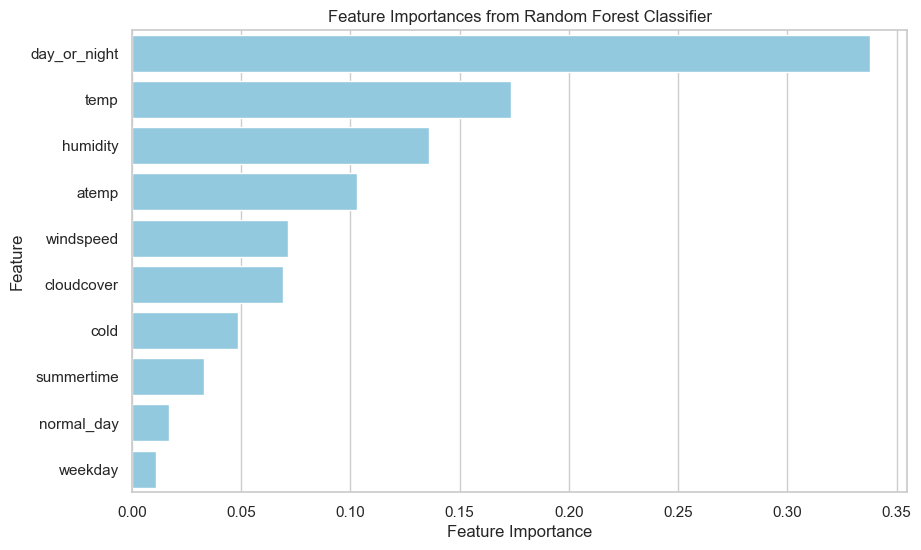

In [15]:
rf_classifier = best_model.named_steps['rf']

# Retrieve feature importances
importances = rf_classifier.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot using Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Classifier')
plt.show()